In [1]:
# Analyzing the effects of different hyperparameters and design choices with small custom
# CNN image classification models on CIFAR-10 dataset
# Comparing and analyzing ResNet50 and MobileNetV2 pretrained on CIFAR-10 dataset

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time

In [3]:
# Transforming the images to tensors and normalizing them
transform = transforms.Compose([
    transforms.ToTensor(),
 #   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

])

In [4]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=False, num_workers=2)


In [5]:
'''
50000 train images
10000 test 

10 classes
0: İmages 1: Labels (0-9)
Size: 3, 32, 32

Data id = i:
trainset[i] -> data i
trainset[i][0] -> image i pixels data
trainset[i][1] -> label data of img i

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

'''

"\n50000 train images\n10000 test \n\n10 classes\n0: İmages 1: Labels (0-9)\nSize: 3, 32, 32\n\nData id = i:\ntrainset[i] -> data i\ntrainset[i][0] -> image i pixels data\ntrainset[i][1] -> label data of img i\n\nclasses = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')\n\n"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


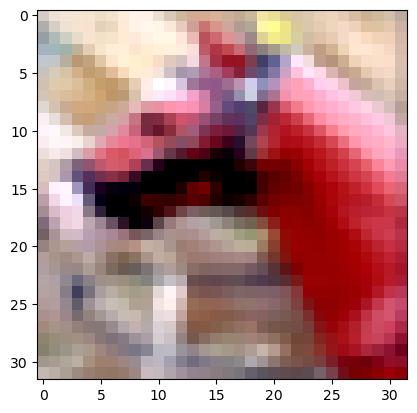

horse


In [6]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

rand_idx = np.random.randint(0, 50000)
# Show images
imshow(torchvision.utils.make_grid(trainset[rand_idx][0]))
label = trainset[rand_idx][1]
print(''.join('%5s' % trainset.classes[label]))


In [7]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3x32x32 -> 6x28x28
        self.pool = nn.MaxPool2d(2, 2) # 6x28x28 -> 6x14x14
         
        self.conv2 = nn.Conv2d(6, 16, 5) # 6x14x14 -> 16x10x10
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16x5x5 -> 120
        self.fc2 = nn.Linear(120, 84) # 120 -> 84
        self.fc3 = nn.Linear(84, 10) # 84 -> 10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
class LargerNet(nn.Module):
    def __init__(self, kernel_size=3, pool_size=2):
        super(LargerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size, padding=1) 
        self.conv2 = nn.Conv2d(32, 32, kernel_size, padding=1) 
        self.conv3 = nn.Conv2d(32, 64, kernel_size, padding=1) 
        self.conv4 = nn.Conv2d(64, 64, kernel_size, padding=1) 
        self.conv5 = nn.Conv2d(64, 128, kernel_size, padding=1) 
        self.conv6 = nn.Conv2d(128, 128, kernel_size, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        x = F.relu(self.conv1(x)) # 3x32x32 -> 32x32x32
        x = self.bn1(x)
        x = F.relu(self.conv2(x)) # 32x32x32 -> 32x32x32
        x = self.bn1(x)
        x = self.pool(x) # 32x32x32 -> 32x16x16
        x = F.dropout(x, p=0.25)  # 32x16x16 -> 32x16x16

        x = F.relu(self.conv3(x)) # 32x16x16 -> 64x16x16
        x = self.bn2(x)
        x = F.relu(self.conv4(x)) # 64x16x16 -> 64x16x16
        x = self.bn2(x)
        x = self.pool(x) # 64x16x16 -> 64x8x8
        x = F.dropout(x, p=0.25) # 64x8x8 -> 64x8x8

        x = F.relu(self.conv5(x)) # 64x8x8 -> 128x8x8
        x = self.bn3(x)
        x = F.relu(self.conv6(x)) # 128x8x8 -> 128x8x8
        x = self.bn3(x)
        x = self.pool(x) # 128x8x8 -> 128x4x4
        x = F.dropout(x, p=0.25)    # 128x4x4 -> 128x4x4

        x = x.view(-1, 128*4*4) 

        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.25)
        x = F.softmax(self.fc2(x))
        return x

In [27]:
net = BaseNet()
loss_history = []
total_time = 0
batch_size = 20

In [28]:
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)#, momentum=0.5)
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.95)



In [30]:
start = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs/255.0)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      #  scheduler.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f learning rate: %f' % 
                  (epoch + 1, i + 1, running_loss / 20, optimizer.param_groups[0]['lr']))

            loss_history.append( running_loss / 20)
            running_loss = 0.0
end = time.time()
total_time += end - start
print('Finished Training')
print('Time: ', end - start)

/tmp/ipykernel_39856/1560469719.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


[1,    20] loss: 2.371 learning rate: 0.000857
[1,    40] loss: 2.402 learning rate: 0.000857
[1,    60] loss: 2.135 learning rate: 0.000857
[1,    80] loss: 2.383 learning rate: 0.000857
[1,   100] loss: 2.360 learning rate: 0.000857
[1,   120] loss: 2.312 learning rate: 0.000857


KeyboardInterrupt: 

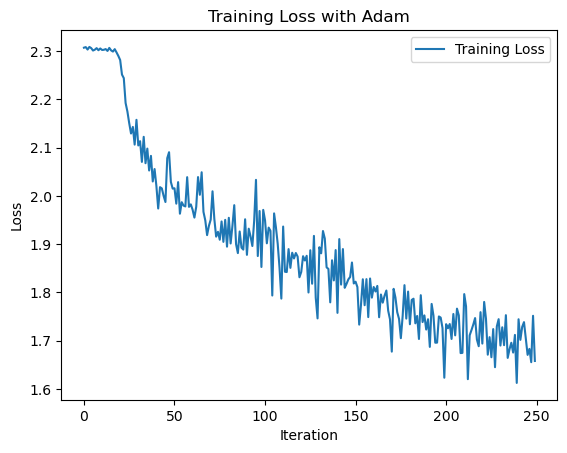

In [ ]:
plt.figure()
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss with Adam')
plt.legend()
plt.show()

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 23 %
